## Tasas implicitas de Futuros

In [1]:

import requests
import pandas as pd
from datetime import date, timedelta
from bcra import *

end = date.today()
start = end - timedelta(days=30)

# API endpoint
url = "https://apicem.matbarofex.com.ar/api/v2/closing-prices"

# Query parameters
params = {
    "product": "DLR",
    "segment": "Monedas",
    "type": "FUT",
    "excludeEmptyVol": "true",
    "from": start.isoformat(),
    "to": end.isoformat(),
    #"page": "1",
    "pageSize": "500",
    "sortDir": "ASC",
    "market": "ROFX"
}

# Send GET request
response = requests.get(url, params=params)

# Check if request was successful
if response.status_code == 200:
    data = response.json()
    
    # Often APIs return data under a key like "content" or "results"
    # If so, replace 'data' below with data["content"]
    try:
        df = pd.DataFrame(data['data'])
    except ValueError:
        df = pd.json_normalize(data['data'])
    
    #print(df.head())
else:
    print(f"Request failed with status code {response.status_code}")
    print(response.text)

try:
    TAMAR_SERIE = get_tamar_serie(start,end,id_variable=44)
except Exception as e:
    print(f"Error fetching TAMAR_SERIE: {e}")
    TAMAR_SERIE = pd.DataFrame()


# BYMA DATA API
url_simul = 'https://new2.bymadata.com.ar/vanoms-be-core/rest/api/byma/data/quantex/trades-volumes'
payload = '{"layout_oid":4375,"page_number":1,"Content-Type":"application/json"}'


c:\Users\j_jun\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.bcra.gob.ar'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Users\j_jun\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.bcra.gob.ar'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


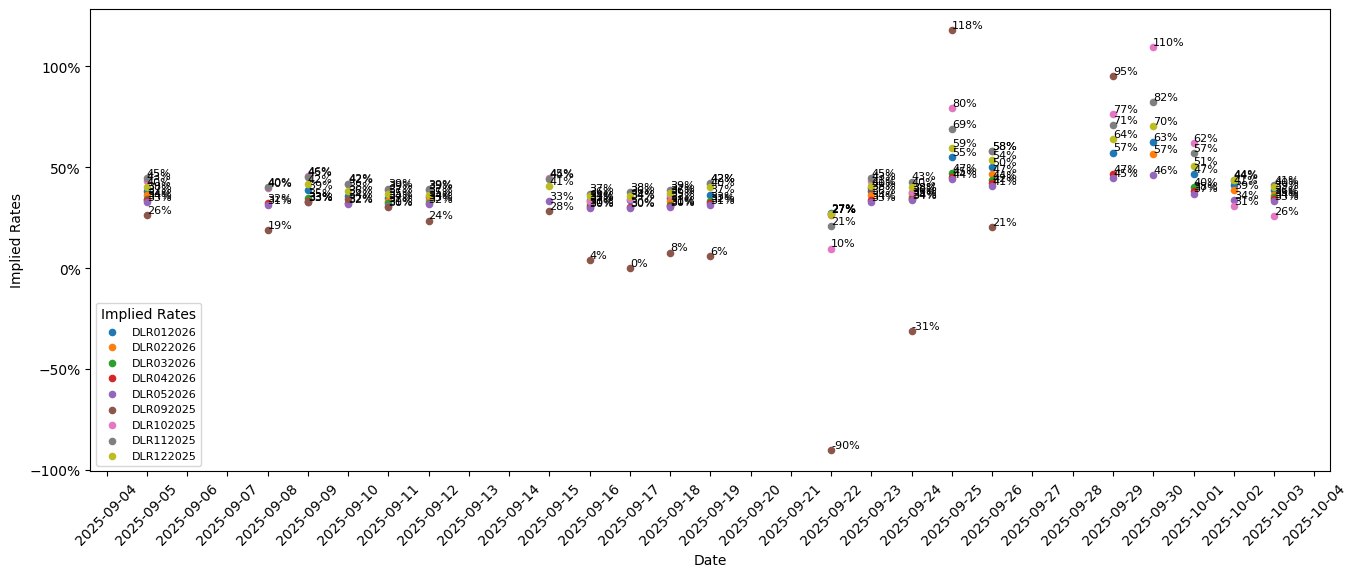

symbol,DLR012026,DLR022026,DLR032026,DLR042026,DLR052026,DLR092025,DLR102025,DLR112025,DLR122025
dateTime,,,,,,,,,
2025-09-05,38.3%,36.5%,34.5%,33.8%,32.9%,26.3%,43.0%,44.6%,40.2%
2025-09-08,nan%,nan%,nan%,32.1%,31.2%,19.1%,39.6%,40.2%,nan%
2025-09-09,38.7%,nan%,34.8%,33.5%,32.8%,32.9%,45.7%,45.1%,41.7%
2025-09-10,36.0%,nan%,nan%,32.1%,31.7%,34.2%,41.6%,42.0%,38.2%
2025-09-11,34.9%,33.6%,32.1%,nan%,30.9%,30.2%,38.8%,39.5%,36.8%
2025-09-12,35.1%,33.7%,32.5%,nan%,31.7%,23.6%,38.8%,39.3%,36.5%
2025-09-15,nan%,nan%,nan%,nan%,33.2%,28.3%,44.5%,44.4%,40.7%
2025-09-16,34.0%,32.6%,31.2%,30.4%,29.8%,4.2%,33.1%,37.0%,35.7%
2025-09-17,33.7%,nan%,nan%,30.5%,29.9%,0.2%,34.4%,37.8%,36.0%


Text(0.5, 1.0, 'Tasa TAMAR Bancsos Privados')

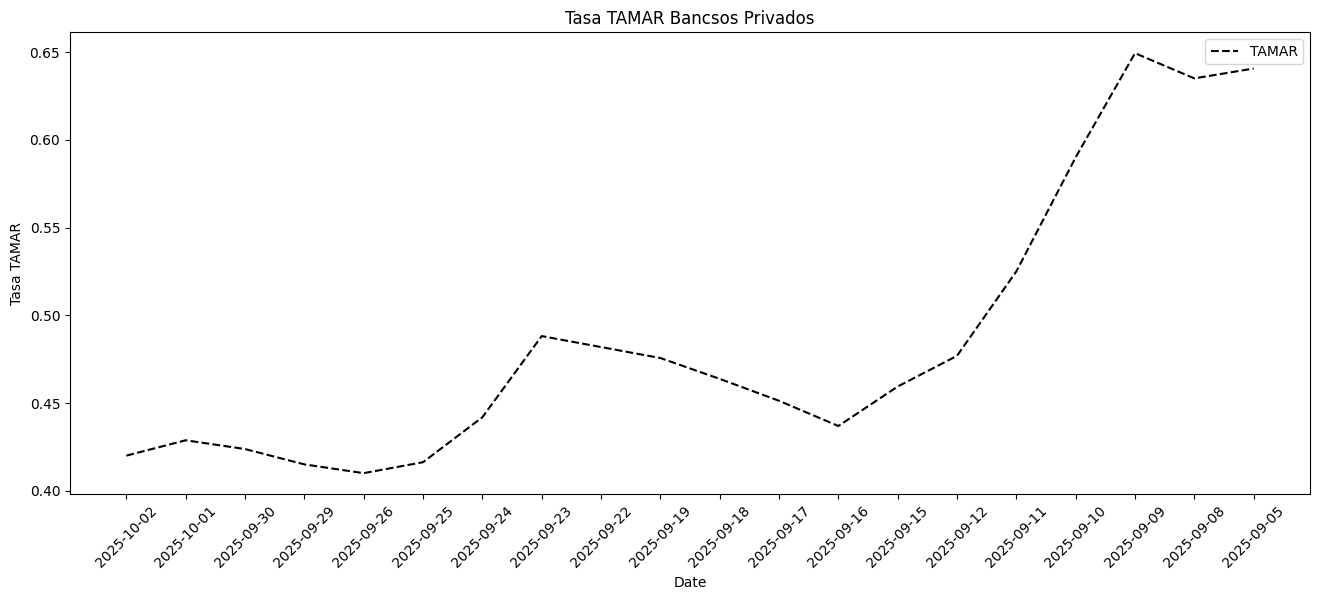

In [ ]:

from IPython.display import display, HTML
rates = df[df['volume'] > 10000].pivot(index='dateTime',columns='symbol',values=['impliedRate'])
rates.index = pd.to_datetime(rates.index)
cols = rates.count()
rates = rates[[c for c in cols.index if cols[c] > 10]] # Keep only columns with more than 10 non-NA values

rates.columns = rates.columns.droplevel(0)  # Drop the top level of the MultiIndex
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import numpy as np
from scipy.interpolate import make_interp_spline

def plot_smooth(df, k=3, n_points=400, figsize=(16,6)):
    """
    Plot smooth curves for each column in a DataFrame using cubic spline interpolation.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with a DatetimeIndex and numeric columns (e.g. interest rates).
    k : int, optional
        Degree of the spline (default=3 for cubic).
    n_points : int, optional
        Number of points for interpolation (default=300).
    figsize : tuple, optional
        Size of the figure (default=(12,6)).
    """
    df = df/100
    df.index = pd.to_datetime(df.index)
    df.reset_index(inplace=True)
    dates = df['dateTime']
    df.drop(columns=['dateTime'], inplace=True)
    df.columns
    fig, ax = plt.subplots(figsize=figsize)
    x = np.arange(len(df.index))  # numeric representation of dates

    for col in df.columns:
        y = df[col].dropna().values
        x = dates[df[col].dropna().index]
        y_ = df[col].fillna(0).values  # for scatter plot
        x_col = np.arange(len(y))  # adjust for missing values

        if len(y) > k:  # spline needs enough points
            spline = make_interp_spline(x_col, y, k=k)
            x_smooth = np.linspace(x_col.min(), x_col.max(), n_points)
            y_smooth = spline(x_smooth)

            # Map x back to datetime index
            dates_smooth = np.linspace(df.index[0], df.index[-1], n_points)

            #ax.plot(x_smooth, y_smooth)
            ax.scatter(x, y, s=20, label=col)  # original points
            for x, y in zip(x, y):
                ax.text(x, y, f"{y*100:.0f}%", ha="left", va="bottom", fontsize=8)

        else:
            #pass
            ax.plot(dates, y_, label=col)  # fallback: straight line
    #ax.plot(TAMAR_SERIE.index, TAMAR_SERIE['valor']/100, label='TAMAR Bancos Privados', color='black', linestyle='--')
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))  # every 1 day
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax.set_xlabel("Date")
    ax.set_ylabel("Implied Rates")
    ax.legend()
    plt.xticks(rotation=45)
    plt.legend(title= 'Implied Rates', loc="lower left", fontsize=8)
    plt.show()


def plot_futures(data=rates, kind='line', ylabel="Implied Rate", title="Implied Rates Over Time", legend_name = "Rates"):
    # Ensure index is datetime
    def human_format(num):
        if num >= 1_000_000_000:
            return f"{num/1_000_000_000:.1f}B"
        elif num >= 100_000:
            return f"{num/1_000_000:.1f}M"
        elif num >= 1_000:
            return f"{num/1_000:.1f}k"
        else:
            return str(int(num))
    
    data.index = pd.to_datetime(data.index)

    # Plot all columns
    if kind == 'line':
        ax = data.plot(figsize=(15, 6), kind=kind, marker='o', markersize=4)
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        # Add grid
        plt.grid(True, linestyle="-", alpha=0.6)
    elif kind == 'bar':
        data_bar = data.copy()
        data_bar.index = data_bar.index.strftime("%Y-%m-%d")
        ax = data_bar.plot(figsize=(24, 8), kind=kind, stacked=True, width=0.9)
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(
            lambda x, _: f"{x/1000:.0f}k" if x >= 1000 else f"{int(x)}"
        ))
        
        for container in ax.containers:
            ax.bar_label(container, labels=[human_format(v.get_height()) if v.get_height() > 100000 else "" 
                                    for v in container], 
                 label_type="center", fontsize=8, color="black")

    # Format x-axis: show date every 5 days
    #ax.xaxis.set_ticks(data.index)


    # Rotate labels for readability
    plt.xticks(rotation=45)

    # Add labels and title
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.title(title)

    # Add legend
    plt.legend(title=legend_name, loc="upper left", fontsize=10, ncols=len(data.columns))

    plt.tight_layout()
    plt.show()


plot_smooth(rates)
# Display with larger font size (e.g. 20px)
rates_display = rates.copy()
rates_display = rates_display/100
rates_display.index = rates_display.index.strftime("%Y-%m-%d")
rates_display = rates_display.style.background_gradient(cmap="YlOrRd")
rates_display = rates_display.format("{:.1%}")
display(HTML(rates_display.to_html().replace('<table',
                                '<table style="font-size:10px"')))
#rates.style.background_gradient(cmap="YlOrRd") 
plt.figure(figsize=(16,6))
line, = plt.plot(TAMAR_SERIE.index, TAMAR_SERIE['valor']/100, label='TAMAR Bancos Privados', color='black', linestyle='--')
line.set_label('TAMAR')
plt.legend()
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel('Tasa TAMAR')    
plt.title('Tasa TAMAR Bancos Privados')


## Interes Abierto y Volumen diario


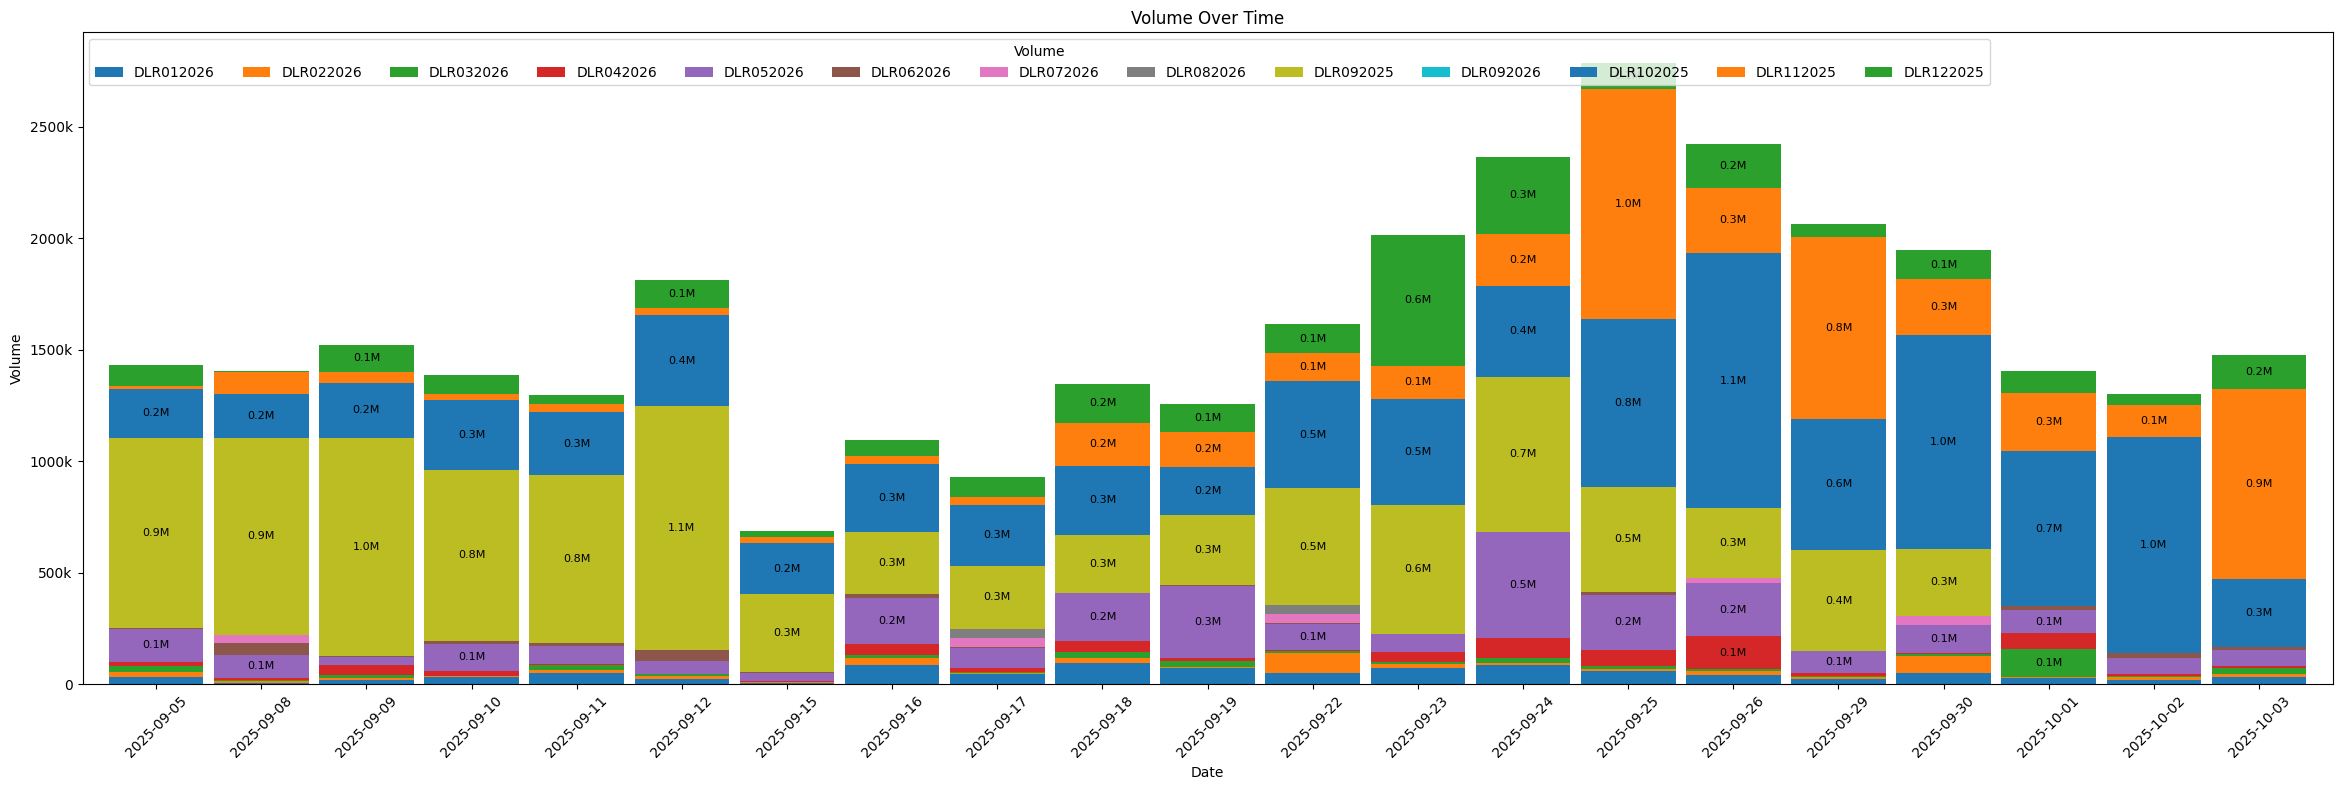

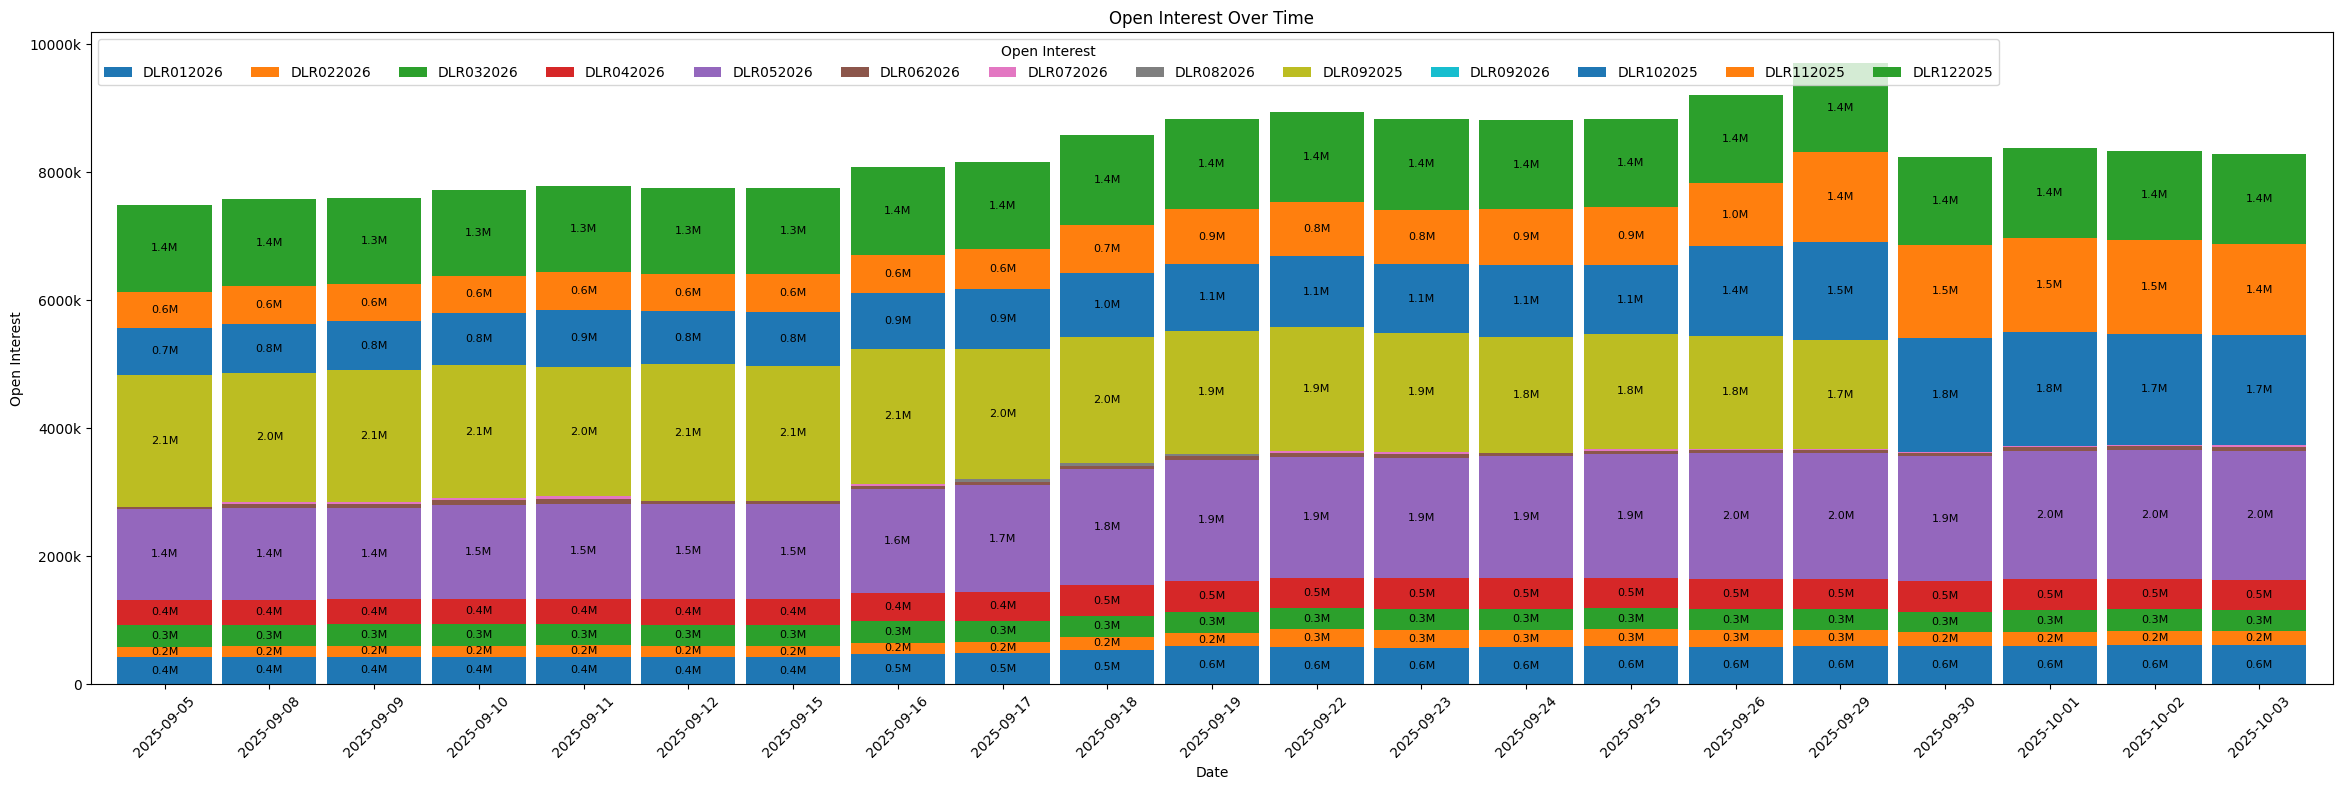

In [11]:

volume = df.pivot(index='dateTime',columns='symbol',values=['volume'])
volume.columns = volume.columns.droplevel(0)  # Drop the top level of the MultiIndex

openInterest = df.pivot(index='dateTime',columns='symbol',values=['openInterest'])
openInterest.columns = openInterest.columns.droplevel(0)  # Drop the top level of the MultiIndex

plot_futures(data=volume, kind='bar', ylabel="Volume", title="Volume Over Time", legend_name = "Volume")
plot_futures(data=openInterest, kind='bar', ylabel="Open Interest", title="Open Interest Over Time", legend_name = "Open Interest")

In [12]:
import matplotlib
print(matplotlib.__version__)

3.8.4
